## Importing

In [1]:
import os
import random
from glob import glob
from collections import Counter
from PIL import Image
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Resize, Normalize
import torchvision
from torch import optim

from tqdm import tqdm


## Hyperparameters and Setup

In [2]:
# Hyperparameters etc
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
LEARNING_RATE = 2e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
Z_DIM = 100
EPOCHS = 10
ROOT_DIR = "/kaggle/working/"
NUM_WORKERS = 2
IMG_DIM = 28 * 28

cuda


## Define The Dataset

In [3]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))
])

train_dataset = datasets.MNIST(root = ROOT_DIR, transform=train_transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
print(f"Total number of images loaded: {len(train_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.97MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.64MB/s]

Total number of images loaded: 60000


['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


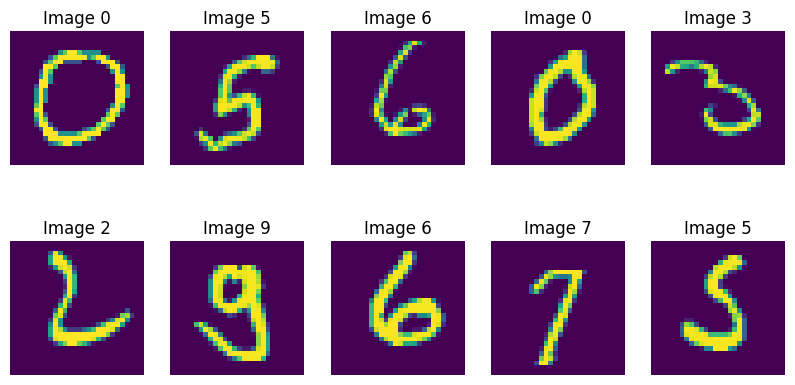

Shape of one image tensor: torch.Size([1, 28, 28])
Shape of a group of iamges is: torch.Size([64, 1, 28, 28])


In [4]:
# To display the images after the transforms
data_iter = iter(train_loader)
images, labels= next(data_iter)

# if it was MNIST or CIFAR10
classes = train_dataset.classes
print(classes)

# Show images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = images[i]
    # print(f" images before reshape {img.shape}")
    img = np.transpose(img.numpy(), (1, 2, 0))  # Convert (C, H, W) to (H, W, C)
    # print(f" images after reshape {img.shape}")
    # img_display = (img + 1) / 2 # if it was normalize use this to recover it
    ax.imshow(img) # expects a numpy
    ax.set_title(f"Image {labels[i]}")
    ax.axis("off")
plt.show()

print("Shape of one image tensor:", images[0].shape)
print("Shape of a group of iamges is:", images.shape)

## Create Vanilla GAN

In [5]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, img_dim=28*28):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, img_dim),
            nn.Tanh()  # Outputs in [-1, 1] to match normalized MNIST
        )

    def forward(self, x):
        return self.model(x)


In [6]:
class Discriminator(nn.Module):
    def __init__(self, img_dim=28*28):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(img_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),#

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid()  # Outputs probability in [0, 1]
        )

    def forward(self, x):
        return self.model(x)


In [7]:
generator = Generator(noise_dim= Z_DIM, img_dim=IMG_DIM)
discriminator = Discriminator(img_dim= IMG_DIM)

generator.to(device)
discriminator.to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

## Training

In [8]:
def train(generator, discriminator, dataloader, epochs = 10, noise_dim=100):
    generator.train()
    discriminator.train()
    d_loss_array = []
    g_loss_array = []

    for epoch in range(epochs):
        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.view(real_images.size(0), -1).to(device) # This flattens each image from [1, 28, 28] into [784]
                                                                                # discriminator expects flat inputs.
            batch_size = real_images.size(0)

            valid = torch.ones(batch_size, 1).to(device) # used with Loss to train the discriminator
            fake = torch.zeros(batch_size, 1).to(device) # used with Loss to train the Generator

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = criterion(discriminator(real_images), valid)
            noise = torch.randn(batch_size, noise_dim).to(device) # to use wit the generator
            fake_images = generator(noise)
            fake_loss = criterion(discriminator(fake_images.detach()), fake) # .detach so the generator is not update here
            d_loss = (real_loss + fake_loss) / 2
            d_loss_array.append(d_loss.item())
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            noise = torch.randn(batch_size, noise_dim).to(device)
            gen_images = generator(noise)
            g_loss = criterion(discriminator(gen_images), valid)
            g_loss_array.append(g_loss.item())
            g_loss.backward()
            optimizer_G.step()

            if i % 300 == 0:
                print(f"[Epoch {epoch+1}/{epochs}] [Batch {i}/{len(dataloader)}] " f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

        save_generated_images(generator, epoch, device, noise_dim)
    return g_loss_array, d_loss_array


In [9]:
def save_generated_images(generator, epoch, device, noise_dim, num_images=16):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_images, noise_dim).to(device)
        generated_imgs = generator(z).cpu().view(num_images, 1, 28, 28)
        grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=True)
        plt.figure(figsize=(6,6))
        plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
        plt.title(f"Generated Images - Epoch {epoch+1}")
        plt.axis('off')
        plt.show()

[Epoch 1/10] [Batch 0/938] [D loss: 0.6864] [G loss: 0.6606]
[Epoch 1/10] [Batch 300/938] [D loss: 0.3837] [G loss: 1.9812]
[Epoch 1/10] [Batch 600/938] [D loss: 0.2221] [G loss: 4.4816]
[Epoch 1/10] [Batch 900/938] [D loss: 0.2352] [G loss: 2.1948]


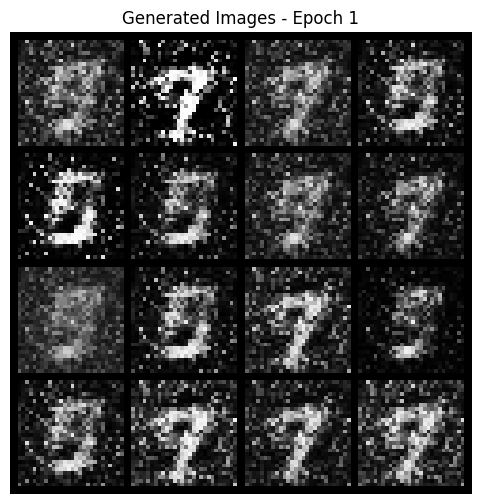

[Epoch 2/10] [Batch 0/938] [D loss: 0.2950] [G loss: 3.2734]
[Epoch 2/10] [Batch 300/938] [D loss: 0.1838] [G loss: 1.8131]
[Epoch 2/10] [Batch 600/938] [D loss: 0.2431] [G loss: 3.8077]
[Epoch 2/10] [Batch 900/938] [D loss: 0.1622] [G loss: 3.2591]


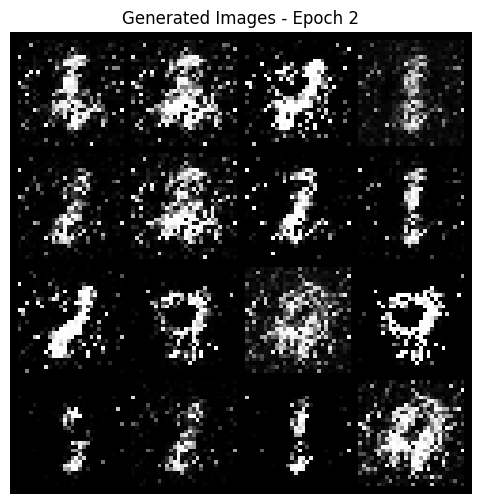

[Epoch 3/10] [Batch 0/938] [D loss: 0.2125] [G loss: 3.0733]
[Epoch 3/10] [Batch 300/938] [D loss: 0.4166] [G loss: 2.8490]
[Epoch 3/10] [Batch 600/938] [D loss: 0.2849] [G loss: 2.9402]
[Epoch 3/10] [Batch 900/938] [D loss: 0.3128] [G loss: 3.5591]


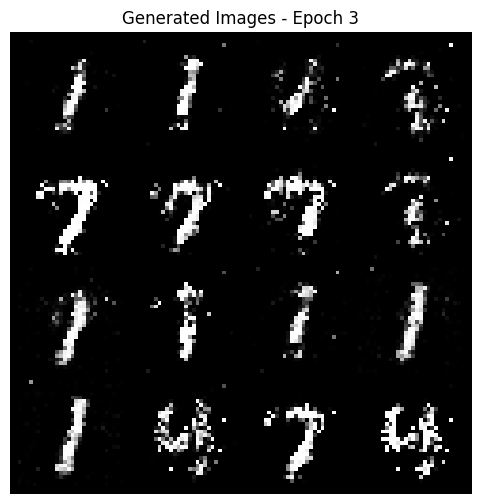

[Epoch 4/10] [Batch 0/938] [D loss: 0.1846] [G loss: 2.9441]
[Epoch 4/10] [Batch 300/938] [D loss: 0.1853] [G loss: 2.3419]
[Epoch 4/10] [Batch 600/938] [D loss: 0.2682] [G loss: 1.8916]
[Epoch 4/10] [Batch 900/938] [D loss: 0.3937] [G loss: 1.6518]


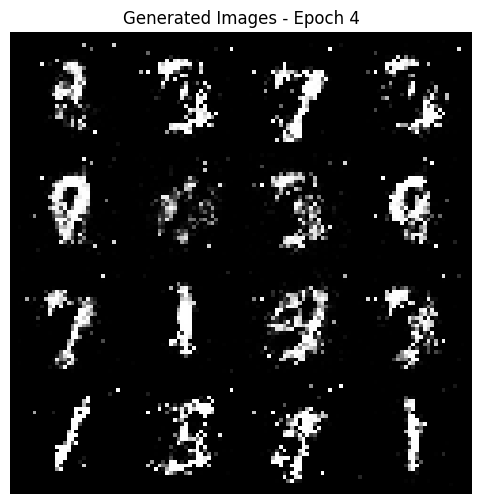

[Epoch 5/10] [Batch 0/938] [D loss: 0.3112] [G loss: 1.3497]
[Epoch 5/10] [Batch 300/938] [D loss: 0.3567] [G loss: 3.0291]
[Epoch 5/10] [Batch 600/938] [D loss: 0.2790] [G loss: 2.0730]
[Epoch 5/10] [Batch 900/938] [D loss: 0.3670] [G loss: 2.6461]


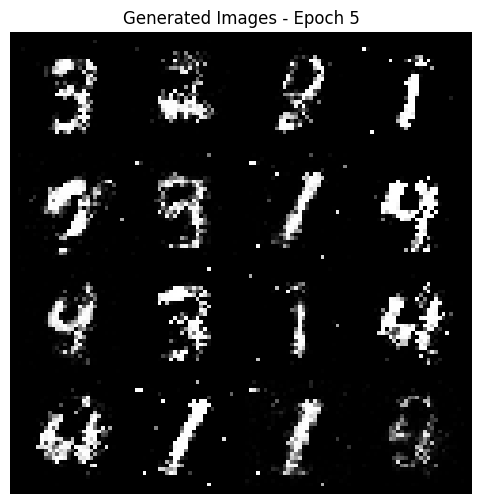

[Epoch 6/10] [Batch 0/938] [D loss: 0.3818] [G loss: 2.4366]
[Epoch 6/10] [Batch 300/938] [D loss: 0.3776] [G loss: 2.5322]
[Epoch 6/10] [Batch 600/938] [D loss: 0.4059] [G loss: 1.9034]
[Epoch 6/10] [Batch 900/938] [D loss: 0.3514] [G loss: 1.2835]


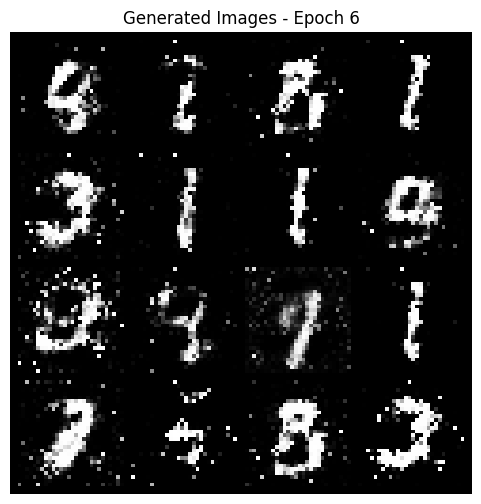

[Epoch 7/10] [Batch 0/938] [D loss: 0.3821] [G loss: 2.3411]
[Epoch 7/10] [Batch 300/938] [D loss: 0.5518] [G loss: 1.2088]
[Epoch 7/10] [Batch 600/938] [D loss: 0.4151] [G loss: 1.5138]
[Epoch 7/10] [Batch 900/938] [D loss: 0.3832] [G loss: 1.6466]


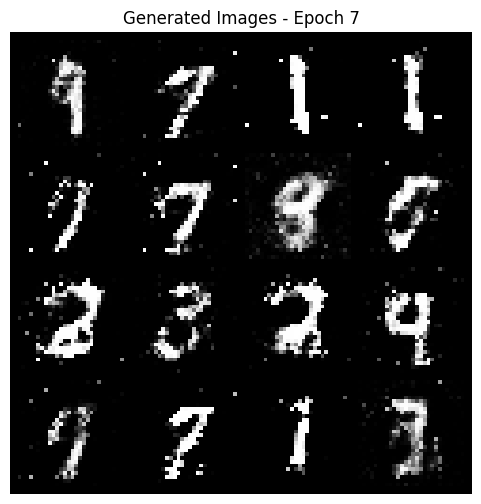

[Epoch 8/10] [Batch 0/938] [D loss: 0.4179] [G loss: 1.5319]
[Epoch 8/10] [Batch 300/938] [D loss: 0.3836] [G loss: 1.5830]
[Epoch 8/10] [Batch 600/938] [D loss: 0.4734] [G loss: 1.5832]
[Epoch 8/10] [Batch 900/938] [D loss: 0.4774] [G loss: 1.2780]


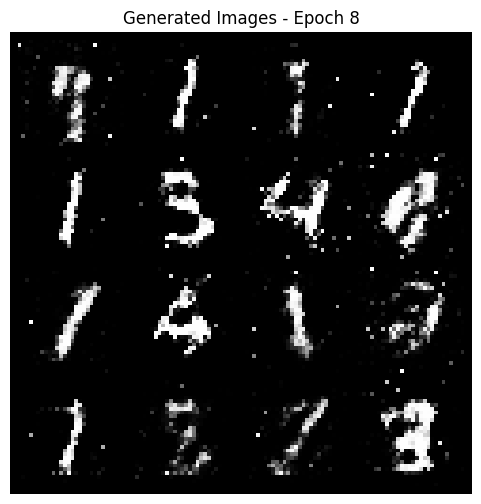

[Epoch 9/10] [Batch 0/938] [D loss: 0.4917] [G loss: 1.2729]
[Epoch 9/10] [Batch 300/938] [D loss: 0.5805] [G loss: 1.0995]
[Epoch 9/10] [Batch 600/938] [D loss: 0.5178] [G loss: 1.1501]
[Epoch 9/10] [Batch 900/938] [D loss: 0.5329] [G loss: 0.9697]


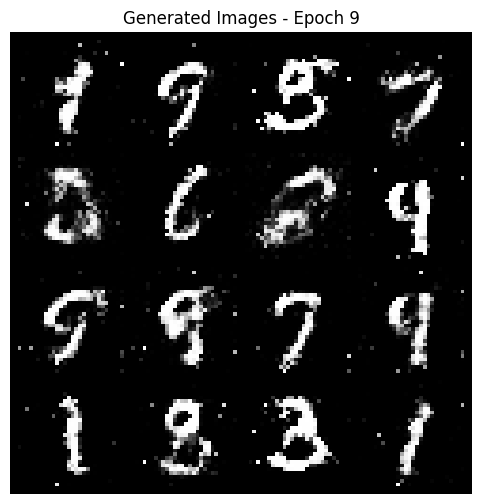

[Epoch 10/10] [Batch 0/938] [D loss: 0.4975] [G loss: 1.3596]
[Epoch 10/10] [Batch 300/938] [D loss: 0.4512] [G loss: 1.3171]
[Epoch 10/10] [Batch 600/938] [D loss: 0.4732] [G loss: 1.1993]
[Epoch 10/10] [Batch 900/938] [D loss: 0.5032] [G loss: 0.8762]


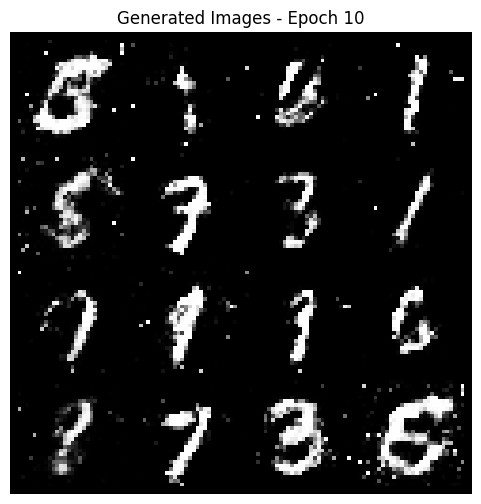

In [10]:
g_loss, d_loss = train(generator, discriminator, train_loader, epochs=EPOCHS)

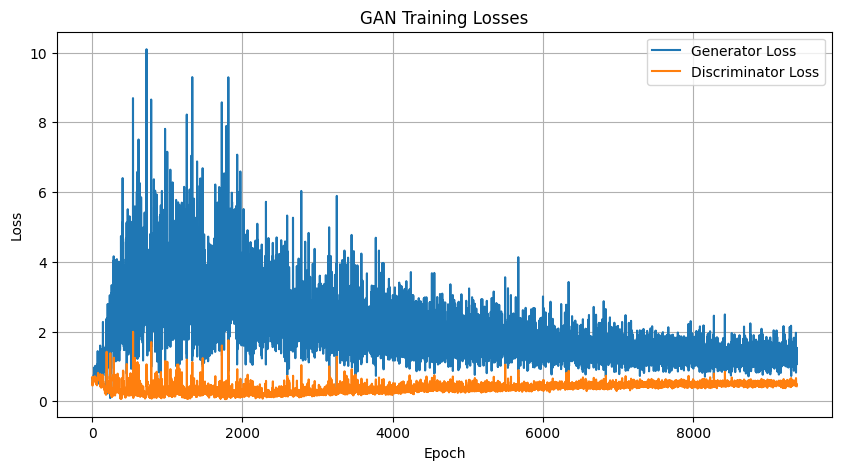

In [11]:
def plot_losses(gen_losses, disc_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Losses')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_losses(g_loss, d_loss)

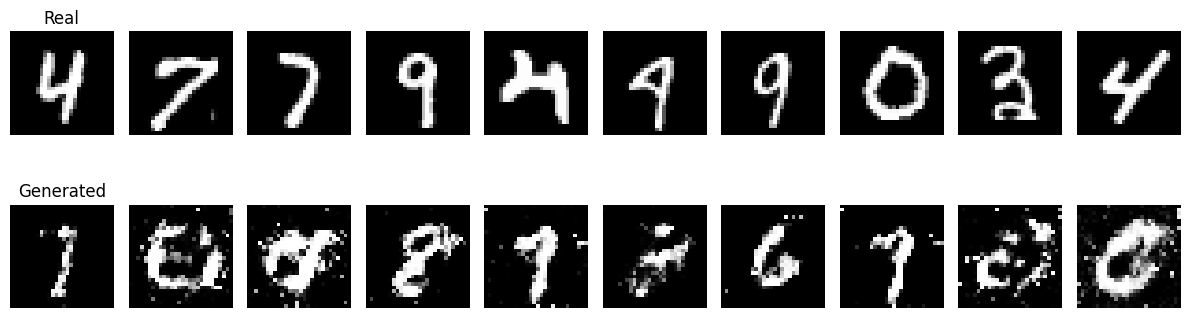

In [12]:
def compare_real_vs_fake(train_loader, generator, noise_dim, n_images):

    # Get real images
    real_images = next(iter(train_loader))[0][:n_images]
    real_images = real_images.squeeze()

    # Generate fake images
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(n_images, noise_dim).to(device)
        fake_images = generator(noise).view(n_images, 28, 28)

    # Plot comparison
    fig, axes = plt.subplots(2, n_images, figsize=(12, 4))

    for i in range(n_images):
        # Real images
        axes[0, i].imshow(real_images[i].cpu().numpy(), cmap='gray')
        axes[0, i].set_title('Real' if i == 0 else '')
        axes[0, i].axis('off')

        # Fake images
        axes[1, i].imshow(fake_images[i].cpu().numpy(), cmap='gray')
        axes[1, i].set_title('Generated' if i == 0 else '')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()
compare_real_vs_fake(train_loader, generator, Z_DIM, n_images = 10)
